# DND challenge rating with machine learning

In this notebook, I work through a linear regression method of generating a challenge rating (CR) based on the stats and abilities of a given monster in DND. 

The data was taken from user shadowtime2000 on Kaggle, link: https://www.kaggle.com/shadowtime2000/dungeons-dragons

## Importing

First, import the necessary tools. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from ast import literal_eval
%matplotlib inline

Now, let's import the data and take a look. 

In [2]:
data = pd.read_csv("data/monsters.csv")

In [3]:
data.head()

,Unnamed: 0,_id,index,name,size,type,subtype,alignment,armor_class,hit_points,...,condition_immunities,senses,languages,challenge_rating,special_abilities,actions,legendary_actions,url,reactions,other_speeds
0,0,5f2329ad0b1bb138c59411ee,aboleth,Aboleth,Large,aberration,NaN,lawful evil,17,135,...,[],"{'darkvision': '120 ft.', 'passive_perception'...","Deep Speech, telepathy 120 ft.",10.00,"[{'name': 'Amphibious', 'desc': 'The aboleth c...","[{'name': 'Multiattack', 'desc': 'The aboleth ...","[{'name': 'Detect', 'desc': 'The aboleth makes...",/api/monsters/aboleth,NaN,NaN
1,1,5f2329ad0b1bb138c59411ef,acolyte,Acolyte,Medium,humanoid,any race,any alignment,10,9,...,[],{'passive_perception': 12},any one language (usually Common),0.25,"[{'name': 'Spellcasting', 'desc': 'The acolyte...","[{'name': 'Club', 'desc': 'Melee Weapon Attack...",NaN,/api/monsters/acolyte,NaN,NaN
2,2,5f2329ad0b1bb138c59411f1,adult-black-dragon,Adult Black Dragon,Huge,dragon,NaN,chaotic evil,19,195,...,[],"{'blindsight': '60 ft.', 'darkvision': '120 ft...","Common, Draconic",14.00,"[{'name': 'Amphibious', 'desc': 'The dragon ca...","[{'name': 'Multiattack', 'desc': 'The dragon c...","[{'name': 'Detect', 'desc': 'The dragon makes ...",/api/monsters/adult-black-dragon,NaN,NaN
3,3,5f2329ad0b1bb138c59411f0,adult-blue-dragon,Adult Blue Dragon,Huge,dragon,NaN,lawful evil,19,225,...,[],"{'blindsight': '60 ft.', 'darkvision': '120 ft...","Common, Draconic",16.00,"[{'name': 'Legendary Resistance', 'desc': 'If ...","[{'name': 'Multiattack', 'desc': 'The dragon c...","[{'name': 'Detect', 'desc': 'The dragon makes ...",/api/monsters/adult-blue-dragon,NaN,NaN
4,4,5f2329ad0b1bb138c59411f2,adult-brass-dragon,Adult Brass Dragon,Huge,dragon,NaN,chaotic good,18,172,...,[],"{'blindsight': '60 ft.', 'darkvision': '120 ft...","Common, Draconic",13.00,"[{'name': 'Legendary Resistance', 'desc': 'If ...","[{'name': 'Multiattack', 'desc': 'The dragon c...",NaN,/api/monsters/adult-brass-dragon,NaN,NaN


In [4]:
data.describe()

,Unnamed: 0,armor_class,hit_points,strength,dexterity,constitution,intelligence,wisdom,charisma,challenge_rating
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,160.500000,14.031056,81.291925,15.161491,12.624224,15.080745,7.754658,11.686335,9.683230,4.543090
std,93.097619,3.256285,99.425430,6.736612,3.202185,4.506105,5.704460,2.934020,5.789584,5.892224
min,0.000000,5.000000,1.000000,1.000000,1.000000,8.000000,1.000000,3.000000,1.000000,0.000000
25%,80.250000,12.000000,18.250000,11.000000,10.000000,12.000000,2.000000,10.000000,5.000000,0.500000
50%,160.500000,13.000000,45.000000,16.000000,13.000000,14.000000,7.000000,12.000000,8.000000,2.000000
75%,240.750000,17.000000,114.000000,19.000000,15.000000,18.000000,12.000000,13.000000,14.000000,6.000000
max,321.000000,25.000000,676.000000,30.000000,28.000000,30.000000,25.000000,25.000000,30.000000,30.000000


So the data is very nice! It's clean enough that I don't need to clean it myself, but some of the values are not usable in a linear regression model. Below, I am going to convert the number of actions, ractions, seneses, lenegary actions, and special abilities to numbers so that they can be factors in my model. 


## Cleaning and preparing

In [5]:
# data = data[data.legendary_actions.notna() == False]
# data = data[data.special_abilities.notna() == False]

# data.legendary_actions = data.legendary_actions.notna().mul(1)
# data.special_abilities = data.special_abilities.notna().mul(1)
#out = ast.literal_eval(data['legendary_actions'][0])
data.legendary_actions.fillna("[]", inplace=True)
data.legendary_actions = data.legendary_actions.apply(literal_eval)
data.legendary_actions = data.legendary_actions.apply(len)

data.special_abilities.fillna("[]", inplace=True)
data.special_abilities = data.special_abilities.apply(literal_eval)
data.special_abilities = data.special_abilities.apply(len)

data.actions.fillna("[]", inplace=True)
data.actions = data.actions.apply(literal_eval)
data.actions = data.actions.apply(len)

data.reactions.fillna("[]", inplace=True)
data.reactions = data.reactions.apply(literal_eval)
data.reactions = data.reactions.apply(len)

data.senses.fillna("[]", inplace=True)
data.senses = data.senses.apply(literal_eval)
data.senses = data.senses.apply(len)


In [6]:
data.head()

,Unnamed: 0,_id,index,name,size,type,subtype,alignment,armor_class,hit_points,...,condition_immunities,senses,languages,challenge_rating,special_abilities,actions,legendary_actions,url,reactions,other_speeds
0,0,5f2329ad0b1bb138c59411ee,aboleth,Aboleth,Large,aberration,NaN,lawful evil,17,135,...,[],2,"Deep Speech, telepathy 120 ft.",10.00,3,4,3,/api/monsters/aboleth,0,NaN
1,1,5f2329ad0b1bb138c59411ef,acolyte,Acolyte,Medium,humanoid,any race,any alignment,10,9,...,[],1,any one language (usually Common),0.25,1,1,0,/api/monsters/acolyte,0,NaN
2,2,5f2329ad0b1bb138c59411f1,adult-black-dragon,Adult Black Dragon,Huge,dragon,NaN,chaotic evil,19,195,...,[],3,"Common, Draconic",14.00,2,6,3,/api/monsters/adult-black-dragon,0,NaN
3,3,5f2329ad0b1bb138c59411f0,adult-blue-dragon,Adult Blue Dragon,Huge,dragon,NaN,lawful evil,19,225,...,[],3,"Common, Draconic",16.00,1,6,3,/api/monsters/adult-blue-dragon,0,NaN
4,4,5f2329ad0b1bb138c59411f2,adult-brass-dragon,Adult Brass Dragon,Huge,dragon,NaN,chaotic good,18,172,...,[],3,"Common, Draconic",13.00,1,6,0,/api/monsters/adult-brass-dragon,0,NaN


In [7]:
data.describe()

,Unnamed: 0,armor_class,hit_points,strength,dexterity,constitution,intelligence,wisdom,charisma,senses,challenge_rating,special_abilities,actions,legendary_actions,reactions
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,160.500000,14.031056,81.291925,15.161491,12.624224,15.080745,7.754658,11.686335,9.683230,1.866460,4.543090,1.649068,2.590062,0.279503,0.034161
std,93.097619,3.256285,99.425430,6.736612,3.202185,4.506105,5.704460,2.934020,5.789584,0.663367,5.892224,1.242228,1.596226,0.897981,0.181927
min,0.000000,5.000000,1.000000,1.000000,1.000000,8.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.250000,12.000000,18.250000,11.000000,10.000000,12.000000,2.000000,10.000000,5.000000,1.000000,0.500000,1.000000,1.000000,0.000000,0.000000
50%,160.500000,13.000000,45.000000,16.000000,13.000000,14.000000,7.000000,12.000000,8.000000,2.000000,2.000000,1.000000,2.000000,0.000000,0.000000
75%,240.750000,17.000000,114.000000,19.000000,15.000000,18.000000,12.000000,13.000000,14.000000,2.000000,6.000000,2.000000,4.000000,0.000000,0.000000
max,321.000000,25.000000,676.000000,30.000000,28.000000,30.000000,25.000000,25.000000,30.000000,3.000000,30.000000,6.000000,7.000000,5.000000,1.000000


And there we go, now we see that all 322 monsters have a number of abilities and legendary actions ranging from 0 to 6 and 0 to 5 respectively. 

Now, I am going to take only certian features. I do not want to consider every feature for this model since they are either going to be very small differences or simply not well known/used in DND gameplay. 

For this, I am going to take the following stats: 
* armor_class: how high of a roll is needed to hit the monster
* hit_points: how many points of damage the monster can take before fainting/dying. 
* legendary_actions: how many legendary actions (attacks or spellcasting abilities taken outside of a creature's turn) the monster has.
* special_abilities: how many special abilities (an extraordinary, spell-like, or supernatural in nature) the monster has.
* actions: how many actions (such as attack, interaction with the environment, etc) a monster has per turn. 
* reactions: how many reactions (an instant response to a trigger of some kind, which can occur on anybody's turn) a monster has. 
* senses: how many senses (abilitiy to see, abilitiy to see in the dark, etc) a monster has. 
* strength: how hard a monster hits something, how much it can carry, and how well it tends to do with strength based skill checks.
* dexterity: determines speed. It is how fast a monster is, as well as how successful it is with ranged attacks.
* constitution: has a direct effect on a monster's hit points, as well as its resistance to poisoning and the likes.
* intelligence: how smart a monster is. 
* wisdom: how well a monster knows about the world around it as well as how perceptive it is. 
* charisma: how good a monster is with people, as well as some spellcasting. 

First, we want to take only the data described above. 

In [8]:
train1 = data[['armor_class','hit_points','legendary_actions','special_abilities','actions', 'reactions', 'senses','strength','dexterity','constitution','intelligence','wisdom','charisma']]

In [9]:
train1.head()

,armor_class,hit_points,legendary_actions,special_abilities,actions,reactions,senses,strength,dexterity,constitution,intelligence,wisdom,charisma
0,17,135,3,3,4,0,2,21,9,15,18,15,18
1,10,9,0,1,1,0,1,10,10,10,10,14,11
2,19,195,3,2,6,0,3,23,14,21,14,13,17
3,19,225,3,1,6,0,3,25,10,23,16,15,19
4,18,172,0,1,6,0,3,23,10,21,14,13,17


Now that we have that, let's create our model. 

I chose a linear regression model because We want to find a numerical value that relates to many other numerical values. Linear regression is also fast to make and run. 

## Making and examining the model

In [10]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
labels = data['challenge_rating']

In [11]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.1,random_state =2)

In [12]:
reg.fit(x_train,y_train)
reg.score(x_test,y_test)

0.9467992818117311

Initially, we can see that there is a roughly 0.947 score on the data without predicting. This shows that while not strictly linear in relationship, there is a strong relationship between our stats and the output label challenge_rating. 

In [13]:
data[:10][['challenge_rating','armor_class','hit_points','legendary_actions','special_abilities','actions', 'reactions', 'senses','strength','dexterity','constitution','intelligence','wisdom','charisma']]
#train1[:10]

,challenge_rating,armor_class,hit_points,legendary_actions,special_abilities,actions,reactions,senses,strength,dexterity,constitution,intelligence,wisdom,charisma
0,10.00,17,135,3,3,4,0,2,21,9,15,18,15,18
1,0.25,10,9,0,1,1,0,1,10,10,10,10,14,11
2,14.00,19,195,3,2,6,0,3,23,14,21,14,13,17
3,16.00,19,225,3,1,6,0,3,25,10,23,16,15,19
4,13.00,18,172,0,1,6,0,3,23,10,21,14,13,17
5,15.00,19,212,3,2,6,0,3,25,10,23,16,15,19
6,14.00,18,184,3,1,6,0,3,23,12,21,18,15,17
7,17.00,19,256,3,2,6,0,3,27,14,25,16,15,24
8,15.00,19,207,3,2,6,0,3,23,12,21,18,15,17
9,17.00,19,256,3,1,7,0,3,27,10,25,16,13,21


In [14]:
output = data.copy(deep=True)

In [15]:
output["guessed_CR"] = reg.predict(output[['armor_class','hit_points','legendary_actions','special_abilities','actions', 'reactions', 'senses','strength','dexterity','constitution','intelligence','wisdom','charisma']])

In [16]:
output[['guessed_CR', 'challenge_rating','armor_class','hit_points','legendary_actions','special_abilities','actions', 'reactions', 'senses','strength','dexterity','constitution','intelligence','wisdom','charisma']].head(10)

,guessed_CR,challenge_rating,armor_class,hit_points,legendary_actions,special_abilities,actions,reactions,senses,strength,dexterity,constitution,intelligence,wisdom,charisma
0,11.046802,10.00,17,135,3,3,4,0,2,21,9,15,18,15,18
1,0.703671,0.25,10,9,0,1,1,0,1,10,10,10,10,14,11
2,13.630087,14.00,19,195,3,2,6,0,3,23,14,21,14,13,17
3,15.185656,16.00,19,225,3,1,6,0,3,25,10,23,16,15,19
4,9.373638,13.00,18,172,0,1,6,0,3,23,10,21,14,13,17
5,14.939086,15.00,19,212,3,2,6,0,3,25,10,23,16,15,19
6,13.600954,14.00,18,184,3,1,6,0,3,23,12,21,18,15,17
7,16.743517,17.00,19,256,3,2,6,0,3,27,14,25,16,15,24
8,14.784991,15.00,19,207,3,2,6,0,3,23,12,21,18,15,17
9,16.274473,17.00,19,256,3,1,7,0,3,27,10,25,16,13,21


Let's clean it up by rounding. 

In [17]:
output['round_guessed_CR'] = output['guessed_CR'].round(decimals=2)

In [18]:
output[['round_guessed_CR', 'challenge_rating','name',]].sample(n=10, random_state=42)

,round_guessed_CR,challenge_rating,name
173,2.33,1.00,Imp
132,1.99,3.00,Giant Scorpion
197,3.53,2.00,Mimic
9,16.27,17.00,Adult Red Dragon
104,0.43,0.25,Flying Sword
119,3.52,5.00,Giant Crocodile
256,19.46,21.00,Solar
158,3.72,5.00,Half-Red Dragon Veteran
226,2.24,0.25,Pseudodragon
311,6.81,7.00,Young Black Dragon


Initially, we see that our guesses aren't too far off! But how far off are they? 

<AxesSubplot:xlabel='name'>

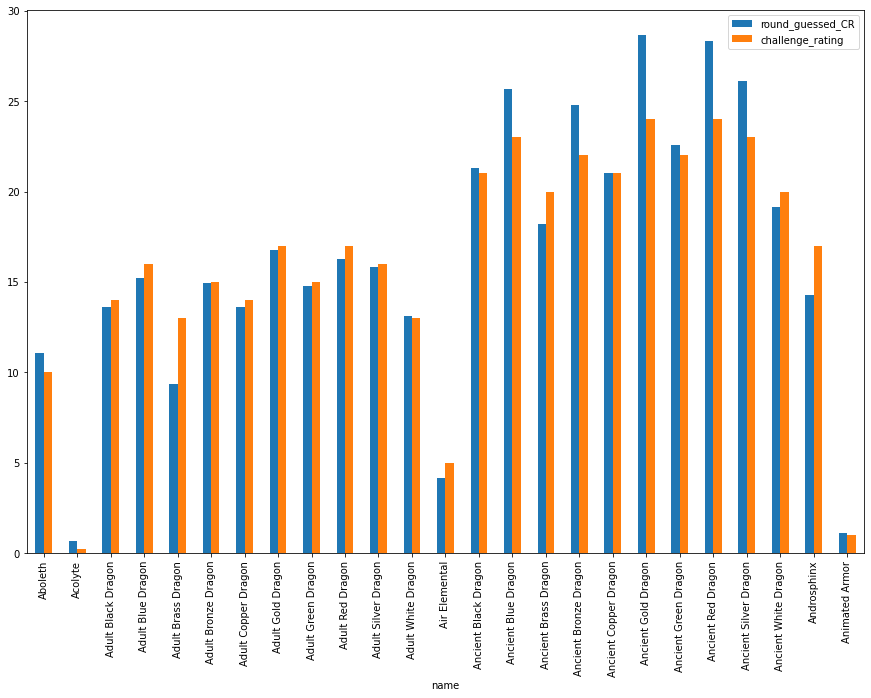

In [19]:
df1 = output[['name', 'round_guessed_CR', 'challenge_rating']].head(25)
df1.plot(x='name', y=['round_guessed_CR', 'challenge_rating'], kind='bar', figsize=(15,10))

This visualisation helps to show that our guesses tended to be close, with some of our higher CR monsters showing the most deviation. 

Let's take a look at these rounded CR guesses and find out what happened! 

In [20]:
output['round_guessed_CR'].describe()

count    322.000000
mean       4.567702
std        5.680325
min       -1.780000
25%        0.755000
50%        2.545000
75%        6.447500
max       32.230000
Name: round_guessed_CR, dtype: float64

In [21]:
output['challenge_rating'].describe()

count    322.000000
mean       4.543090
std        5.892224
min        0.000000
25%        0.500000
50%        2.000000
75%        6.000000
max       30.000000
Name: challenge_rating, dtype: float64

No monster in DND has a CR lower than 0 or above 30, as shown in these two charts. Yet our regression algorithm said that there were! Our mean and standard deviation were pretty close to accurate though, which is great. 

Let's examine our outputs with lower than 0 or higher than 30 CR. 

In [22]:
output[output.round_guessed_CR.values<0]

,Unnamed: 0,_id,index,name,size,type,subtype,alignment,armor_class,hit_points,...,languages,challenge_rating,special_abilities,actions,legendary_actions,url,reactions,other_speeds,guessed_CR,round_guessed_CR
31,31,5f2329ad0b1bb138c594120d,axe-beak,Axe Beak,Large,beast,NaN,unaligned,11,19,...,NaN,0.250,0,1,0,/api/monsters/axe-beak,0,NaN,-0.034586,-0.03
40,40,5f2329ad0b1bb138c5941216,bat,Bat,Tiny,beast,NaN,unaligned,12,1,...,NaN,0.000,2,1,0,/api/monsters/bat,0,NaN,-0.172301,-0.17
57,57,5f2329ad0b1bb138c5941226,camel,Camel,Large,beast,NaN,unaligned,9,15,...,NaN,0.125,0,1,0,/api/monsters/camel,0,NaN,-0.417030,-0.42
58,58,5f2329ad0b1bb138c5941227,cat,Cat,Tiny,beast,NaN,unaligned,12,2,...,NaN,0.000,1,1,0,/api/monsters/cat,0,NaN,-0.032471,-0.03
67,67,5f2329ae0b1bb138c5941230,commoner,Commoner,Medium,humanoid,any race,any alignment,10,4,...,any one language (usually Common),0.000,0,1,0,/api/monsters/commoner,0,NaN,-0.168151,-0.17
68,68,5f2329ae0b1bb138c5941232,constrictor-snake,Constrictor Snake,Large,beast,NaN,unaligned,12,13,...,NaN,0.250,0,2,0,/api/monsters/constrictor-snake,0,NaN,-0.180954,-0.18
71,71,5f2329ae0b1bb138c5941234,crab,Crab,Tiny,beast,NaN,unaligned,11,2,...,NaN,0.000,1,1,0,/api/monsters/crab,0,NaN,-0.728214,-0.73
83,83,5f2329ae0b1bb138c5941241,draft-horse,Draft Horse,Large,beast,NaN,unaligned,10,19,...,NaN,0.250,0,1,0,/api/monsters/draft-horse,0,NaN,-0.236047,-0.24
96,96,5f2329ae0b1bb138c594124d,elk,Elk,Large,beast,NaN,unaligned,10,13,...,NaN,0.250,1,2,0,/api/monsters/elk,0,NaN,-0.304462,-0.30
105,105,5f2329ae0b1bb138c5941256,frog,Frog,Tiny,beast,NaN,unaligned,11,1,...,NaN,0.000,2,0,0,/api/monsters/frog,0,NaN,-0.851208,-0.85


In [23]:
output[output.round_guessed_CR.values>30]

,Unnamed: 0,_id,index,name,size,type,subtype,alignment,armor_class,hit_points,...,languages,challenge_rating,special_abilities,actions,legendary_actions,url,reactions,other_speeds,guessed_CR,round_guessed_CR
278,278,5f2329ae0b1bb138c5941305,tarrasque,Tarrasque,Gargantuan,monstrosity,titan,unaligned,25,676,...,NaN,30.0,4,7,3,/api/monsters/tarrasque,0,NaN,32.226022,32.23


The Terrasque is known for being crazy difficult! Not a surprise that it is given a CR above 30. 

# Conclusion

The linear regression model I made here may not be the best fit for this data. In the future, I may look at using random forest methods and find which features are actually most important, as well as manipulate the data more prior to building the the models. 

Below is some more examination of the CR guesser that looks at the difference between the regression guess and the actual CR. 

In [24]:
output['CR_diff'] = output['round_guessed_CR']-output['challenge_rating']

In [25]:
output[output.CR_diff.values>1].count()

Unnamed: 0                68
_id                       68
index                     68
name                      68
size                      68
type                      68
subtype                   23
alignment                 68
armor_class               68
hit_points                68
hit_dice                  68
speed                     68
strength                  68
dexterity                 68
constitution              68
intelligence              68
wisdom                    68
charisma                  68
proficiencies             68
damage_vulnerabilities    68
damage_resistances        68
damage_immunities         68
condition_immunities      68
senses                    68
languages                 58
challenge_rating          68
special_abilities         68
actions                   68
legendary_actions         68
url                       68
reactions                 68
other_speeds               2
guessed_CR                68
round_guessed_CR          68
CR_diff       

In [26]:
output[output.CR_diff.values>=2].count()

Unnamed: 0                17
_id                       17
index                     17
name                      17
size                      17
type                      17
subtype                    5
alignment                 17
armor_class               17
hit_points                17
hit_dice                  17
speed                     17
strength                  17
dexterity                 17
constitution              17
intelligence              17
wisdom                    17
charisma                  17
proficiencies             17
damage_vulnerabilities    17
damage_resistances        17
damage_immunities         17
condition_immunities      17
senses                    17
languages                 16
challenge_rating          17
special_abilities         17
actions                   17
legendary_actions         17
url                       17
reactions                 17
other_speeds               1
guessed_CR                17
round_guessed_CR          17
CR_diff       

In [27]:
output[output.CR_diff.values>=2]

,Unnamed: 0,_id,index,name,size,type,subtype,alignment,armor_class,hit_points,...,challenge_rating,special_abilities,actions,legendary_actions,url,reactions,other_speeds,guessed_CR,round_guessed_CR,CR_diff
14,14,5f2329ad0b1bb138c59411fb,ancient-blue-dragon,Ancient Blue Dragon,Gargantuan,dragon,NaN,lawful evil,22,481,...,23.0,0,6,3,/api/monsters/ancient-blue-dragon,0,NaN,25.691258,25.69,2.69
16,16,5f2329ad0b1bb138c59411fe,ancient-bronze-dragon,Ancient Bronze Dragon,Gargantuan,dragon,NaN,lawful good,22,444,...,22.0,2,7,3,/api/monsters/ancient-bronze-dragon,0,NaN,24.761256,24.76,2.76
18,18,5f2329ad0b1bb138c5941200,ancient-gold-dragon,Ancient Gold Dragon,Gargantuan,dragon,NaN,lawful good,22,546,...,24.0,2,7,3,/api/monsters/ancient-gold-dragon,0,NaN,28.629497,28.63,4.63
20,20,5f2329ad0b1bb138c5941202,ancient-red-dragon,Ancient Red Dragon,Gargantuan,dragon,NaN,chaotic evil,22,546,...,24.0,1,6,3,/api/monsters/ancient-red-dragon,0,NaN,28.303191,28.30,4.30
21,21,5f2329ad0b1bb138c5941204,ancient-silver-dragon,Ancient Silver Dragon,Gargantuan,dragon,NaN,lawful good,22,487,...,23.0,1,7,3,/api/monsters/ancient-silver-dragon,0,NaN,26.124468,26.12,3.12
32,32,5f2329ad0b1bb138c594120e,azer,Azer,Medium,elemental,NaN,lawful neutral,17,39,...,2.0,3,1,0,/api/monsters/azer,0,NaN,4.042512,4.04,2.04
37,37,5f2329ad0b1bb138c5941213,bandit-captain,Bandit Captain,Medium,humanoid,any race,any non-lawful alignment,15,65,...,2.0,0,3,0,/api/monsters/bandit-captain,1,NaN,4.314632,4.31,2.31
70,70,5f2329ae0b1bb138c5941236,couatl,Couatl,Medium,celestial,NaN,lawful good,19,97,...,4.0,3,3,0,/api/monsters/couatl,0,NaN,8.225160,8.23,4.23
77,77,5f2329ae0b1bb138c594123b,deep-gnome-svirfneblin,Deep Gnome (Svirfneblin),Small,humanoid,gnome,neutral good,15,16,...,0.5,3,2,0,/api/monsters/deep-gnome-svirfneblin,0,NaN,2.517163,2.52,2.02
86,86,5f2329ae0b1bb138c5941245,drider,Drider,Large,monstrosity,NaN,chaotic evil,19,123,...,6.0,5,4,0,/api/monsters/drider,0,NaN,8.539339,8.54,2.54


<BarContainer object of 322 artists>

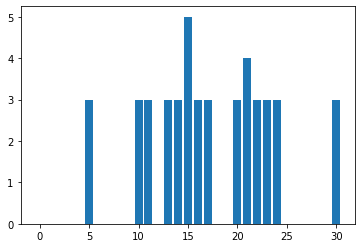

In [28]:
plt.bar(data['challenge_rating'], data['legendary_actions'])

<BarContainer object of 322 artists>

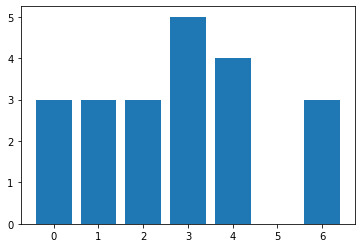

In [29]:
plt.bar(data['special_abilities'], data['legendary_actions'])

<BarContainer object of 322 artists>

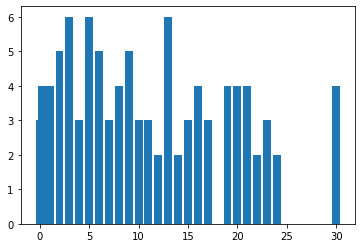

In [30]:
plt.bar(data['challenge_rating'],data['special_abilities'])